In [3]:
#本文档对数据进行预处理
#划分预测训练集
#进行数据可视化
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

##设置绘图的大小
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

In [4]:
# 导入数据
#选用的服务器类型
columns = ["id","ecs","date","time"]
#读取数据
data = pd.read_table('data_set/data_2015_12_to_2016_01.txt',header=None,delim_whitespace=True,names=columns)
#转化成日期格式
data['date'] = pd.to_datetime(data['date'])
#train['date']=pd.to_datetime(train['date'])  

In [5]:
#对数据进行处理
from sklearn import preprocessing
target_ecs = ["flavor1","flavor2","flavor3","flavor4","flavor5","flavor6","flavor7","flavor8","flavor9","flavor10","flavor11","flavor12","flavor13","flavor14","flavor15"]
#首先对数据进行聚合,统计每一种服务器们每天的个数
groupby_data = data.groupby(["date","ecs"]).size().reset_index(name="count")
#生成一个新的时间序列
begin_date = groupby_data.iloc[0]['date']
end_date = groupby_data.iloc[-1]['date']
full_data = pd.DataFrame(index=pd.date_range(begin_date,end_date))
for ecs_type in target_ecs:
    tmp_data = groupby_data[groupby_data["ecs"]==ecs_type]
    tmp_data = tmp_data.set_index("date")
    tmp_data=tmp_data.drop(['ecs'], axis=1)
    tmp_data.rename(columns={'count':ecs_type}, inplace = True)
    full_data = full_data.join(tmp_data).fillna(0)
#print (full_data.head(10))

### h哈觉得
- hadsj
- jdask
- aff

In [6]:
##进行训练集和测试集划分
import datetime
##手动设定训练集和测试集
train_begin_date = datetime.datetime(2015, 12, 1)
train_end_date = datetime.datetime(2016, 1, 20)
test_begin_date = datetime.datetime(2016, 1, 21)
test_end_date = datetime.datetime(2016, 1, 27)
train_data = full_data.iloc[full_data.index >= train_begin_date]
train_data = train_data.iloc[train_data.index <= train_end_date]
test_data = full_data.iloc[full_data.index >= test_begin_date]
test_data = test_data.iloc[test_data.index <= test_end_date]
print(test_data)

            flavor1  flavor2  flavor3  flavor4  flavor5  flavor6  flavor7  \
2016-01-21      5.0      6.0      1.0      2.0      9.0      0.0      0.0   
2016-01-22     10.0      4.0      0.0      1.0      1.0      0.0      0.0   
2016-01-23      1.0      6.0      8.0      0.0      0.0      0.0      0.0   
2016-01-24      2.0      5.0      0.0      1.0      1.0      0.0      0.0   
2016-01-25      8.0      0.0      0.0      2.0     10.0      0.0      1.0   
2016-01-26      1.0      5.0      2.0      0.0      1.0      0.0      0.0   
2016-01-27      2.0      7.0      1.0      5.0      6.0      0.0      1.0   

            flavor8  flavor9  flavor10  flavor11  flavor12  flavor13  \
2016-01-21     10.0      1.0       0.0       0.0       0.0       0.0   
2016-01-22      3.0      3.0       0.0       8.0       7.0       0.0   
2016-01-23     25.0      0.0       0.0       0.0       0.0       0.0   
2016-01-24      7.0      1.0       0.0       2.0       0.0       0.0   
2016-01-25      3.0    

In [7]:
##对test_data进行处理
test_target = {}
for ecs in target_ecs:
    tmp_data = sum(test_data[ecs])
    test_target[ecs] = int(tmp_data)
print(test_target)
##转换成字典格式， 目标虚拟服务器以及数目

{'flavor1': 29, 'flavor2': 33, 'flavor3': 12, 'flavor4': 11, 'flavor5': 28, 'flavor6': 0, 'flavor7': 2, 'flavor8': 60, 'flavor9': 12, 'flavor10': 2, 'flavor11': 18, 'flavor12': 16, 'flavor13': 2, 'flavor14': 4, 'flavor15': 3}


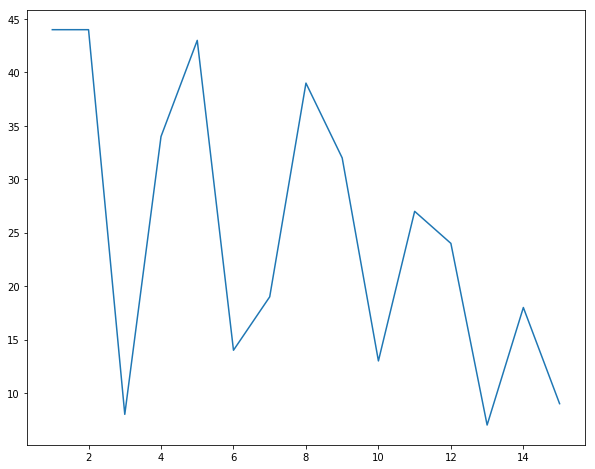

In [8]:
#观察每组数据的分布总天数
count_num = []
count_dict = {}
for ecs in target_ecs:
    tmp_num = len(train_data[ecs][train_data[ecs]>0])
    count_num.append(tmp_num)
    count_dict[ecs] = tmp_num
ecs_index = range(1,16)
plt.plot(ecs_index, count_num)

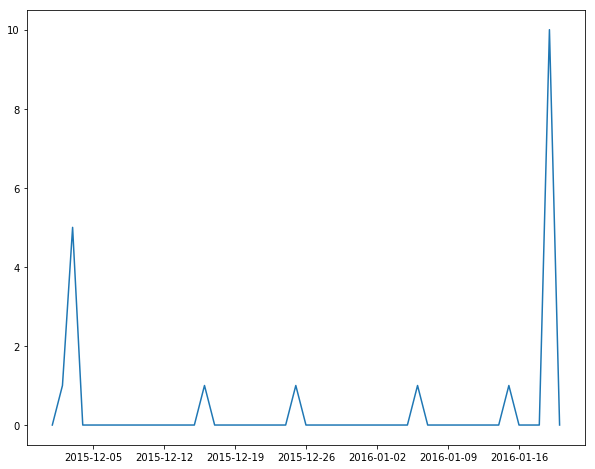

In [9]:
##观察数据集中每一个数据的分布
watch_type = 'flavor13'
watch_data = train_data[watch_type]
plt.plot(watch_data)

### 传统方法的一些检测
- 低频的数据观察
- 周期性检测
- 移动平均后观察

In [10]:
#处理低频次的数据
from huawei.state_predict import mean_value
low_frep = []
date_sum =  int(str(train_end_date - train_begin_date)[0:2])
predict_len = int(str(test_end_date - test_begin_date)[0:2])
base_rate = 0.3
for ecs, freq in count_dict.items():
    if (freq < date_sum*base_rate):
        low_frep.append(ecs)
for ecs in low_frep:
    ecs_data = train_data[ecs]
    print ("当前的虚拟机："+ecs)
    print ("实际值：")
    print (test_target[ecs])
    print ("预测值：")
    print (mean_value(train_data[ecs],date_sum,predict_len))

当前的虚拟机：flavor3
实际值：
12
预测值：
1
当前的虚拟机：flavor6
实际值：
0
预测值：
3
当前的虚拟机：flavor10
实际值：
2
预测值：
2
当前的虚拟机：flavor13
实际值：
2
预测值：
2
当前的虚拟机：flavor15
实际值：
3
预测值：
4


In [11]:
## 使用AR
from statsmodels.tsa.ar_model import AR
from huawei.state_predict import mv_and_ar, get_scores

predict_result = {}
for ecs in target_ecs:
    train_series = train_data[ecs]
    predict_num = mv_and_ar(train_series,test_begin_date,test_end_date,6)
    #print (predictions)
    predict_result[ecs] = int(predict_num)
##修复bug
#predict_result['flavor13'] = 2.0
get_scores(predict_result, test_target,target_ecs)

predict scrore: 0.845446


C:\Users\caocongcong\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)
C:\Users\caocongcong\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)
C:\Users\caocongcong\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)
C:\Users\caocongcong\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)
C:\Users\caocongcong\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is depr

In [22]:
##如果增加频次不够的
mean_predict_result = predict_result
base_rate = 0.1
for ecs, freq in count_dict.items():
    if (freq < date_sum*base_rate):
        low_frep.append(ecs)
        print (ecs)
for ecs in low_frep:
    ecs_data = train_data[ecs]
    mean_predict_result[ecs] = mean_value(train_data[ecs],date_sum,predict_len)
get_scores(mean_predict_result, test_target,target_ecs)

predict scrore: 0.875944
